El objetivo de este notebook es crear un recomendador muy sencillo, que sirva de línea base y con el que poder comparar

In [1]:
from typing import Dict, List, Tuple, Union, Any, Optional

import os
import sys
print("Python version", sys.version)

import numpy as np
import pandas as pd
import itertools as it

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.autonotebook import tqdm

from src.datasets import daocensus_text, to_microsoft
from src.model_selection import timeIntervalSplit, timeFreqSplitCurrent
from src.utils import notebooks as nbutils

sns.set_theme()

Python version 3.9.18 (main, Oct 24 2023, 09:18:18) 
[GCC 11.4.0]


/tmp/ipykernel_3528675/804985562.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# Dataset splits config
N_SPLITS: int = 10

# Always 0, just skip the first rows in the CSV to compare with others
SKIP_SPLIT: int = 0

# the second way of making splits
SPLITS_FREQ: str = 'W-THU'
SPLITS_NORMALIZE: bool = True
LAST_SPLITS: int = 10 # Only used to generate baseline graph

K_RECOMMENDATIONS: List[int] = [5, 10, 15]

ORG_NAME: str = 'Decentraland'
ORG_PLATFORM: str = 'snapshot'
USE_ORG_NAMES: bool = True

CUTOFF_DATE_STR = ... # Not used

In [3]:
# Parameters
ORG_NAME = "PancakeSwap"
ORG_PLATFORM = "snapshot"
SPLITS_FREQ = "3d"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10
USE_ORG_NAMES = True
EXECUTION_ID = "2024-03-08 10:00"
CUTOFF_DATE_STR = "2023-07-01"


# Load data

In [4]:
# dfv, dfp = daocensus.get("./data/daos-census", ORG_NAME, 'snapshot')
# dfptime = pd.read_csv('./snapshot_proposals.csv')[['proposal_id', 'title', 'description', 'start', 'end']]
# dfp = dfp.merge(dfptime, how='left', left_on='platform_proposal', right_on='proposal_id')
# dfp[['start', 'end']] = dfp[['start', 'end']].astype('datetime64')

dfv, dfp = daocensus_text.get("./data/daos-census-text", ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES)
print(dfv.info())
print(dfp.info())

,platform,name,id,proposal,deployment,platform_vote,voter,date,choice,weight
0,snapshot,PancakeSwap,0e1eb2f7-ec2a-59d5-a435-a494d08c5a8b,32d8d279-eb34-5718-9081-4deb1b662a37,e2ec62ae-9b29-5f3a-a541-58678bb64a1b,0xb0fcbc6f10b7c4cf6760924462e6a1ed2b88ceb4d22b...,0x71aa938631f32011303150bd7d1c7f4b5d2f3694,2021-12-07 17:59:03,[0.01],0.0
1,snapshot,PancakeSwap,7bcb7bea-a8e9-5b33-9ea7-3f341e605ad2,32d8d279-eb34-5718-9081-4deb1b662a37,e2ec62ae-9b29-5f3a-a541-58678bb64a1b,0xb25efbe53439436654e7041df8e85347bcd64ad022bc...,0xfee6b5d6fd92e64248e5af14023a19bf0cbaa04a,2021-12-07 17:56:45,[0.01],0.0
2,snapshot,PancakeSwap,d96aa22e-d352-55fe-91de-2316af9f8810,32d8d279-eb34-5718-9081-4deb1b662a37,e2ec62ae-9b29-5f3a-a541-58678bb64a1b,0xe69372429af52eb5571f60402c01184c3f5207cbca28...,0x077f6c80a1c43a63db6892b85bed5205c0afbc4f,2021-12-07 17:27:49,[0.01],0.0
3,snapshot,PancakeSwap,5adbc4f5-a08b-57e1-923d-84f9e38d0189,32d8d279-eb34-5718-9081-4deb1b662a37,e2ec62ae-9b29-5f3a-a541-58678bb64a1b,0x23e095e99d27bbf8458cd87f20b56df18d758a570a06...,0x5473b5210b996ac3809996e9e9dd4d716d3df08c,2021-12-07 17:22:02,[0.01],0.0
4,snapshot,PancakeSwap,ecabb2af-bd29-5f46-9e5c-dcb09c49508a,32d8d279-eb34-5718-9081-4deb1b662a37,e2ec62ae-9b29-5f3a-a541-58678bb64a1b,0xf5042f86a7745f82206c7f327b3276229783e443f2df...,0xe99ce54c794408f6c162f9dc4e7fedc4ab3a04f2,2021-12-07 13:59:15,[0.01],0.0
...,...,...,...,...,...,...,...,...,...,...
532825,snapshot,PancakeSwap,4f04c278-65df-5f7d-b129-03add4a93efb,993ffb33-adc7-5c95-aa0e-39e1dff59ddb,e2ec62ae-9b29-5f3a-a541-58678bb64a1b,QmSaVbd3MLbvwQJgP63MwdXnRzvJobB194bSosHNewBum7,0x7fdcd2e33e371ec87b95bbffc2554e0b2009e446,2021-08-05 06:17:17,[0],0.0
532826,snapshot,PancakeSwap,22ba3cac-316f-5f3f-9c7e-fc0a2e8b8d8c,993ffb33-adc7-5c95-aa0e-39e1dff59ddb,e2ec62ae-9b29-5f3a-a541-58678bb64a1b,QmYTkUwPM9jzZwj9228uKUgDbHfxwjdCam8FjChUZXxTTS,0xcffc400e997df71f4b69ecd70534a918830f9691,2021-08-05 06:17:18,[0],0.0
532827,snapshot,PancakeSwap,5abcef64-bbcc-568a-a44d-5605112f7da4,993ffb33-adc7-5c95-aa0e-39e1dff59ddb,e2ec62ae-9b29-5f3a-a541-58678bb64a1b,QmSQhyP5VVbCv9UwFJQoXW5zeJJbnQcjjKRPRCLb2WS29T,0x70818eed32bbf091b6a00a4e5f10b92cb1ac5335,2021-08-05 06:17:26,[0],0.0
532828,snapshot,PancakeSwap,32b55e8f-53c8-5680-884e-67daa32cbf46,993ffb33-adc7-5c95-aa0e-39e1dff59ddb,e2ec62ae-9b29-5f3a-a541-58678bb64a1b,QmSLiiQP5MgEbSnaS6htcedsRLGh9nRcCWRL7iB2NZ1Y33,0xe452962479546db940f53052af3c03dbf8a4c08b,2021-08-05 06:17:41,[0],0.0


Warning, removing 532830 votes without proposal


<class 'pandas.core.frame.DataFrame'>
Int64Index: 532830 entries, 0 to 532829
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   platform       532830 non-null  object        
 1   name           532830 non-null  object        
 2   id             532830 non-null  object        
 3   proposal       532830 non-null  category      
 4   deployment     532830 non-null  object        
 5   platform_vote  532830 non-null  object        
 6   voter          532830 non-null  category      
 7   date           532830 non-null  datetime64[ns]
 8   choice         532830 non-null  object        
 9   weight         532830 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 40.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2691 entries, 0 to 2690
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------

In [5]:
df = to_microsoft(dfv)
df.head()

,userID,itemID,timestamp,rating
0,0x71aa938631f32011303150bd7d1c7f4b5d2f3694,32d8d279-eb34-5718-9081-4deb1b662a37,2021-12-07 17:59:03,1
1,0xfee6b5d6fd92e64248e5af14023a19bf0cbaa04a,32d8d279-eb34-5718-9081-4deb1b662a37,2021-12-07 17:56:45,1
2,0x077f6c80a1c43a63db6892b85bed5205c0afbc4f,32d8d279-eb34-5718-9081-4deb1b662a37,2021-12-07 17:27:49,1
3,0x5473b5210b996ac3809996e9e9dd4d716d3df08c,32d8d279-eb34-5718-9081-4deb1b662a37,2021-12-07 17:22:02,1
4,0xe99ce54c794408f6c162f9dc4e7fedc4ab3a04f2,32d8d279-eb34-5718-9081-4deb1b662a37,2021-12-07 13:59:15,1


# Exploring data

## How much time does each proposal take

Most proposals take a week, but there are a few that take less than 7 days.

count                           2691
mean      25 days 15:21:30.978446674
std      152 days 18:02:07.925171586
min                  0 days 00:00:57
25%                  3 days 00:00:00
50%                  6 days 11:00:00
75%                 23 days 00:15:00
max               7360 days 13:15:00
dtype: object

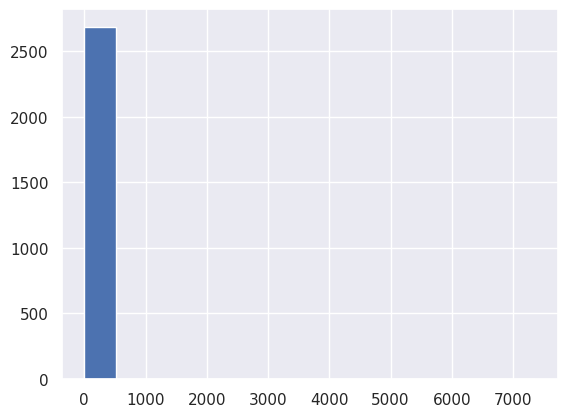

In [6]:
delta = dfp['end'] - dfp['start']
delta.dt.days.hist(bins=14)
delta.describe()

### Just for MetaCartel, avg proposal length in time

<Axes: xlabel='date'>

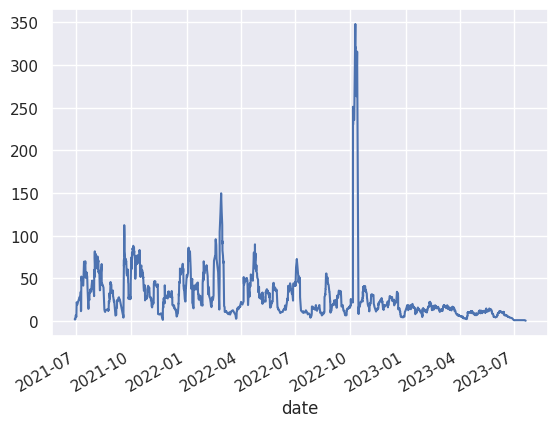

In [7]:
# TODO
_delta = dfp.assign(delta=delta).set_index('date').sort_index()['delta'].dt.days
_delta.rolling('7D').mean().plot()

## What day or the week are proposals created

Thursday     458
Friday       439
Wednesday    421
Tuesday      373
Monday       373
Saturday     329
Sunday       298
Name: start, dtype: int64

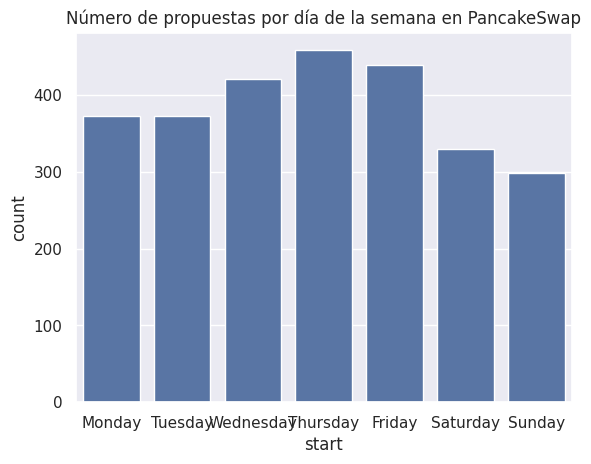

In [8]:
import seaborn as sns

ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
dfp['start'].dt.day_name().value_counts()

Thursday     99867
Friday       95520
Wednesday    80942
Tuesday      79282
Saturday     67887
Monday       67112
Sunday       42220
Name: date, dtype: int64

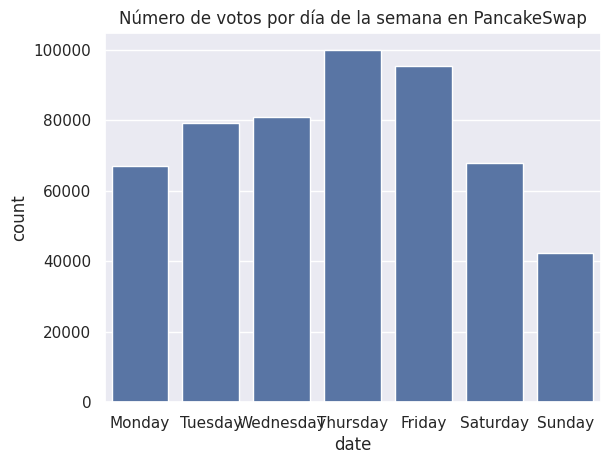

In [9]:
ax = sns.countplot(x=dfv['date'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.set_title(f'Número de votos por día de la semana en {ORG_NAME}')
dfv['date'].dt.day_name().value_counts()

## Ahora en porcentaje acumulado

<Axes: xlabel='rel_day', ylabel='proposals'>

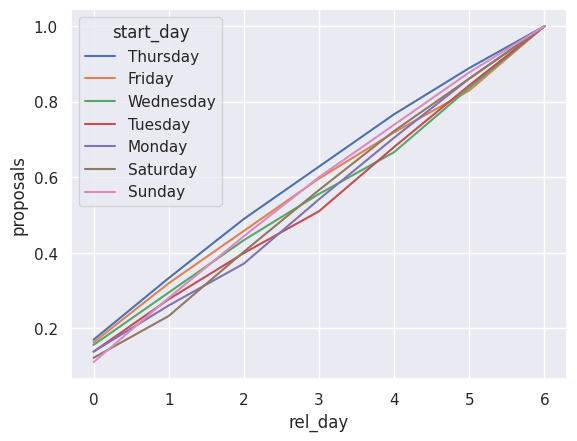

In [10]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfp['start'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='proposals') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='proposals', hue='start_day')

### Same with votes

<Axes: xlabel='rel_day', ylabel='votes'>

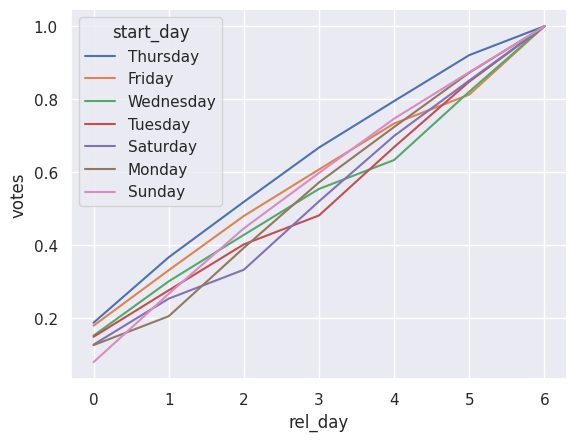

In [11]:
# ax = sns.countplot(x=dfp['start'].dt.day_name(), order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
# ax.set_title(f'Número de propuestas por día de la semana en {ORG_NAME}')
# dfp['start'].dt.day_name().value_counts()

start_from = 2

vc = dfv['date'].dt.day_name().value_counts()
vc = vc / vc.sum()
series = []
for i, d in enumerate(vc.index):
    newindex = vc.index[i:].union(vc.index[:i], sort=False)
    assert len(newindex) == 7
    assert newindex[0] == d
    
    s = vc.reindex(newindex) \
        .cumsum() \
        .to_frame(name='votes') \
        .reset_index().rename(columns={'index': 'day'}) \
        .reset_index().rename(columns={'index': 'rel_day'})
    s['start_day'] = d
    series.append(s)

sns.lineplot(pd.concat(series), x='rel_day', y='votes', hue='start_day')

## How many proposals are created per week

As we can see, there are peaks of over 70 proposals created in a week, using a recommendator can help the users know which proposals to chose.

<Axes: xlabel='start'>

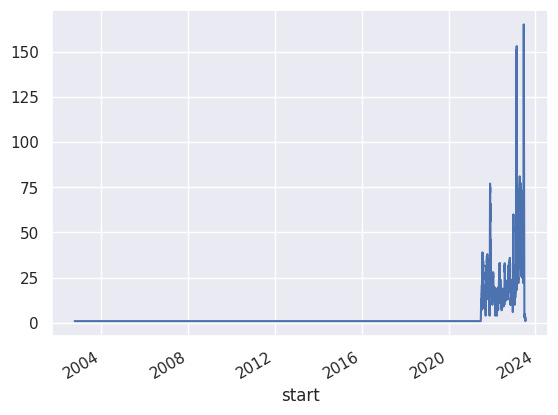

In [12]:
dfp.set_index('start').sort_index().rolling('7d')['id'].count().plot()

## VPP in test per recommendator

In [13]:
freqs = ['W-SUN', 'W-MON', 'W-TUE', 'W-WED', 'W-THU', 'W-SAT']
freq = freqs[0]

results = []
for freq in tqdm(freqs, leave=False):
    for dftrain, dftest, t, openproposals in timeFreqSplitCurrent(to_microsoft(dfv), freq, dfp.reset_index(), return_open=True, remove_not_in_train_col='userID'):
        dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
        
        results.append({
            'f': freq,
            't': t,
            # 'proposals in train': dftrain['itemID'].nunique(),
            # 'votes in train': len(dftrain),
            'votes in open proposals (train)': len(dftrain_filter),
            'users in open proposals (train)': dftrain_filter['userID'].nunique(),
            'open proposals': len(openproposals),
            'votes in test': len(dftest),
            'users in test': dftest['userID'].nunique(),
        })

res = pd.DataFrame(results)
res['vpp test'] = res['votes in test'] / res['open proposals']
res['vpu test'] = res['votes in test'] / res['users in test']
res.groupby('f').describe(percentiles=[]).T[freqs]

  0%|          | 0/6 [00:00<?, ?it/s]

f                                             W-SUN         W-MON  \
votes in open proposals (train) count    106.000000    106.000000   
                                mean   14428.500000  14372.896226   
                                std    10583.521061  10601.043100   
                                min      132.000000    132.000000   
                                50%    14530.000000  14604.500000   
                                max    42712.000000  41643.000000   
users in open proposals (train) count    106.000000    106.000000   
                                mean    6658.896226   6580.037736   
                                std     5004.956633   5024.396265   
                                min      118.000000    118.000000   
                                50%     7360.500000   7392.000000   
                                max    26246.000000  25843.000000   
open proposals                  count    106.000000    106.000000   
                                mean      80.726415     81.075472   
                                std       27.690993     28.279118   
                                min        5.000000      5.000000   
                                50%       85.000000     85.000000   
                                max      142.000000    147.000000   
votes in test                   count    106.000000    106.000000   
                                mean     677.547170    655.084906   
                                std      978.797806    919.568793   
                                min       63.000000     47.000000   
                                50%      391.500000    349.000000   
                                max     7515.000000   7010.000000   
users in test                   count    106.000000    106.000000   
                                mean     199.367925    179.745283   
                                std      144.283539    122.250411   
                                min       30.000000     27.000000   
                                50%      140.500000    140.000000   
                                max      651.000000    569.000000   
vpp test                        count    106.000000    106.000000   
                                mean       8.821321      8.382913   
                                std       10.256178      9.293285   
                                min        1.239583      1.146341   
                                50%        4.985915      4.313146   
                                max       54.456522     50.071429   
vpu test                        count    106.000000    106.000000   
                                mean       3.038025      3.154587   
                                std        2.032896      2.041594   
                                min        1.166667      1.204420   
                                50%        2.518774      2.538909   
                                max       16.887640     16.455399   

f                                             W-TUE         W-WED  \
votes in open proposals (train) count    107.000000    107.000000   
                                mean   14412.514019  14453.504673   
                                std    10720.653570  10839.534940   
                                min       21.000000    239.000000   
                                50%    14590.000000  14718.000000   
                                max    41643.000000  41643.000000   
users in open proposals (train) count    107.000000    107.000000   
                                mean    6644.121495   6716.467290   
                                std     5030.051522   5110.029419   
                                min       19.000000    210.000000   
                                50%     7234.000000   7476.000000   
                                max    25843.000000  25843.000000   
open proposals                  count    107.000000    107.000000   
                                mean      80.906542     80.626168 

In [14]:
res.groupby('f').sum().T[freqs]

/tmp/ipykernel_3528675/4276310820.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  res.groupby('f').sum().T[freqs]


f,W-SUN,W-MON,W-TUE,W-WED,W-THU,W-SAT
votes in open proposals (train),1.529421e+06,1.523527e+06,1.542139e+06,1.546525e+06,1.558227e+06,1.549224e+06
users in open proposals (train),7.058430e+05,6.974840e+05,7.109210e+05,7.186620e+05,7.320050e+05,7.183170e+05
open proposals,8.557000e+03,8.594000e+03,8.657000e+03,8.627000e+03,8.676000e+03,8.660000e+03
votes in test,7.182000e+04,6.943900e+04,7.762900e+04,7.596500e+04,8.287900e+04,8.087600e+04
users in test,2.113300e+04,1.905300e+04,2.635000e+04,2.356700e+04,2.746600e+04,2.757500e+04
vpp test,9.350600e+02,8.885887e+02,9.986801e+02,9.806726e+02,1.071152e+03,1.077795e+03
vpu test,3.220306e+02,3.343862e+02,2.919904e+02,3.106960e+02,3.128241e+02,3.012122e+02


# Defining the baseline recommendator

Our baseline RecSys will be just recommending the top most famous proposals at time $t$.

In [15]:
from src.baseline import getBaselineRecommendations

"""
def getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):
    bestVotes = train['itemID'].value_counts()
    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])

    if remove_train:
        df = filter_by(df, train, ['userID', 'itemID'])
        
    df = df.groupby('userID').head(k).reset_index(drop=True)

    df['prediction'] = True
    return df
"""

# getBaselineRecommendations(folds[0][0], folds[0][1]['userID'].unique(), 3)

"\ndef getBaselineRecommendations(train: pd.DataFrame, users, k: int = 5, remove_train=True):\n    bestVotes = train['itemID'].value_counts()\n    df = pd.DataFrame(it.product(users, bestVotes.index), columns=['userID', 'itemID'])\n\n    if remove_train:\n        df = filter_by(df, train, ['userID', 'itemID'])\n        \n    df = df.groupby('userID').head(k).reset_index(drop=True)\n\n    df['prediction'] = True\n    return df\n"

# Evaluating the baseline recommendator with `timeIntervalSplit`

In [16]:
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k

In [17]:
def check_train_recs(df, filter_by_df, filter_by_cols):
    return any(df.set_index(filter_by_cols).index.isin(
        filter_by_df.set_index(filter_by_cols).index
    ))

In [18]:
from collections import defaultdict

folds = list(timeIntervalSplit(df, N_SPLITS, skip=SKIP_SPLIT, remove_not_in_train_col='userID'))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
# perfectmetrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(folds):
    t = train.timestamp.max()
    print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    print(f"Train votes in open proposals: {len(train_filtered):3}")
    print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False
        
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    print()

===== Training on fold 0 (t: 2021-09-04 20:04:51)  =====
Currently open proposals: 41
Train votes in open proposals: 1758
Test votes in open proposals:  310



===== Training on fold 1 (t: 2021-11-12 04:10:22)  =====
Currently open proposals: 107
Train votes in open proposals: 9573
Test votes in open proposals:  1019



===== Training on fold 2 (t: 2022-01-19 12:06:19)  =====
Currently open proposals: 97
Train votes in open proposals: 41288
Test votes in open proposals:  944



===== Training on fold 3 (t: 2022-03-28 19:21:38)  =====
Currently open proposals: 79
Train votes in open proposals: 40143
Test votes in open proposals:  477



===== Training on fold 4 (t: 2022-06-05 03:28:16)  =====
Currently open proposals: 89
Train votes in open proposals: 17115
Test votes in open proposals:  1016



===== Training on fold 5 (t: 2022-08-12 11:35:53)  =====
Currently open proposals: 81
Train votes in open proposals: 15306
Test votes in open proposals:  916



===== Training on fold 6 (t: 2022-10-19 19:38:51)  =====
Currently open proposals: 98
Train votes in open proposals: 15256
Test votes in open proposals:  730



===== Training on fold 7 (t: 2022-12-27 03:46:44)  =====
Currently open proposals: 102
Train votes in open proposals: 20345
Test votes in open proposals:  1608



===== Training on fold 8 (t: 2023-03-05 11:57:33)  =====
Currently open proposals: 113
Train votes in open proposals: 9422
Test votes in open proposals:  732



===== Training on fold 9 (t: 2023-05-12 19:49:13)  =====
Currently open proposals: 79
Train votes in open proposals: 4973
Test votes in open proposals:  615


In [19]:
# from src import paths

# Won't even save it because its not used
# pd.DataFrame(metrics).to_csv(paths.baseline_mp(ORG_NAME, N_SPLITS), index=False)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.037925,0.083911,0.063474,0.097569,0.034486,0.103636,0.072765,0.153185,0.036328,0.125112,0.080899,0.220483,0.395442,0.231768
std,0.046160,0.129453,0.116521,0.152820,0.033423,0.149723,0.126608,0.207456,0.028752,0.160376,0.131788,0.242336,0.052780,0.039155
min,0.007560,0.007958,0.001685,0.003573,0.006186,0.013361,0.003020,0.006498,0.005498,0.017389,0.006525,0.032731,0.335570,0.188942
25%,0.009504,0.014899,0.006676,0.017323,0.015326,0.020159,0.009788,0.035201,0.021090,0.034057,0.012036,0.060732,0.369889,0.207790
50%,0.014703,0.016748,0.008468,0.023493,0.023356,0.043458,0.017617,0.073281,0.026106,0.067617,0.026963,0.136329,0.388347,0.225806
75%,0.039960,0.060678,0.030203,0.071210,0.032663,0.063986,0.033802,0.096506,0.042090,0.077451,0.039170,0.193440,0.403373,0.246140
max,0.131544,0.368012,0.346946,0.391858,0.101339,0.448018,0.381246,0.594168,0.090030,0.482962,0.398082,0.684523,0.518415,0.324709


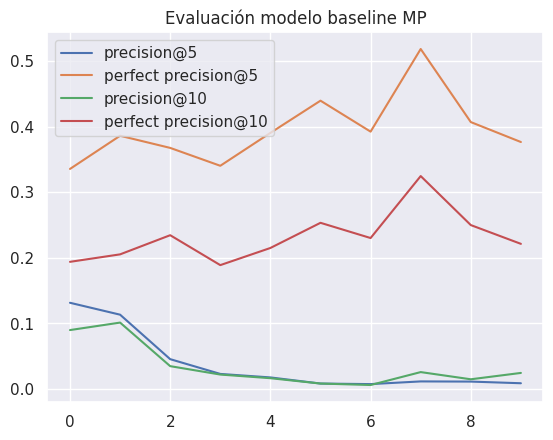

In [20]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,10.000000,10.0,10.000000,10.000000,10.000000,10.0,10.000000,10.000000,10.000000,10.0,10.000000,10.000000
mean,0.395442,1.0,0.954223,0.954223,0.231768,1.0,0.983503,0.983503,0.165099,1.0,0.991873,0.991873
std,0.052780,0.0,0.021515,0.021515,0.039155,0.0,0.010511,0.010511,0.030077,0.0,0.006364,0.006364
min,0.335570,1.0,0.917098,0.917098,0.188942,1.0,0.961039,0.961039,0.131991,1.0,0.977726,0.977726
25%,0.369889,1.0,0.940061,0.940061,0.207790,1.0,0.979730,0.979730,0.141989,1.0,0.989198,0.989198
50%,0.388347,1.0,0.955998,0.955998,0.225806,1.0,0.985959,0.985959,0.160436,1.0,0.993434,0.993434
75%,0.403373,1.0,0.970218,0.970218,0.246140,1.0,0.987649,0.987649,0.179387,1.0,0.996572,0.996572
max,0.518415,1.0,0.983731,0.983731,0.324709,1.0,0.996162,0.996162,0.231391,1.0,0.998110,0.998110


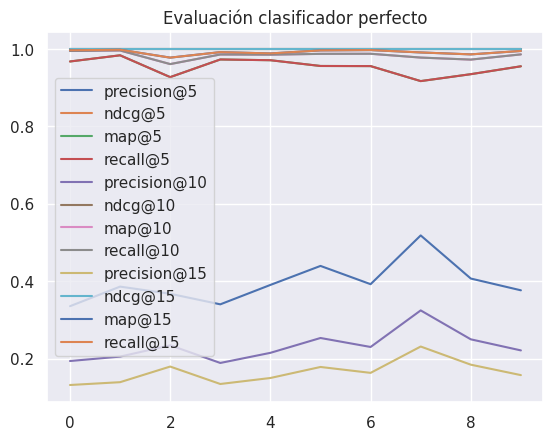

In [21]:
pmdf = pd.DataFrame(perfectmetrics)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

# Evaluation the baseline recommendator with `timeFreqSplit`

In [22]:
from tqdm.autonotebook import tqdm

In [23]:
from functools import partial
import sys

folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics_f = { 'precision':precision_at_k, 'ndcg': ndcg_at_k, 'ndcg': ndcg_at_k, 'map': map_at_k, 'recall': recall_at_k, }
# metrics = {n+f'@{k}':[] for k,n in it.product(K_RECOMMENDATIONS, metrics_f.keys())}
metrics = defaultdict(list)
perfectmetrics = defaultdict(list)

for i, (train, test) in enumerate(tqdm(folds)):
    t = train.timestamp.max()

    assert not train.empty, f"Train should not be empty on fold {i}"
    # assert not test.empty, f"Test should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i}", file=sys.stderr)
    # print(f"===== Training on fold {i} (t: {t})  =====")
    # print(f"Ratings train: {len(train)}, test: {len(test)}")

    open_proposals = dfp[(dfp['start'] < t) & (t < dfp['end']) ]['id'].unique()
    # print(f"Currently open proposals: {len(open_proposals)}")

    train_filtered = train[train['itemID'].isin(open_proposals) ]
    test_filtered = test[test['itemID'].isin(open_proposals) ]
    # print(f"Train votes in open proposals: {len(train_filtered):3}")
    # print(f"Test votes in open proposals:  {len(test_filtered):3}")    

    # print('Tested score:')
    metrics['t'].append(t)
    perfectmetrics['t'].append(t)
    for k_recs in K_RECOMMENDATIONS:
        recs = getBaselineRecommendations(train, test_filtered['userID'].unique(), open_proposals, k_recs)
    
        if check_train_recs(recs, train_filtered, ['userID', 'itemID']):
            print("There are recommendations that were true in training")
            assert False

        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            metrics[m+f'@{k_recs}'].append(r)
            
        # print('Perfect predictor score:')
        recs = test_filtered.copy()
        recs['prediction'] = True
        for m, f in metrics_f.items():
            r = f(test_filtered, recs, k=k_recs)
            # print(f'  {m}@{k_recs}:'.ljust(15), f'{r:.3}')
            perfectmetrics[m+f'@{k_recs}'].append(r)
    
    # print()

  0%|          | 0/249 [00:00<?, ?it/s]

In [24]:
print(df['timestamp'].min(), df['timestamp'].max())
_folds = list(timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE, inclusive='right', return_open=True))
_, _, t, _ = _folds[0]
print("t0:", t)
_, _, t, _ = _folds[1]
print("t1:", t)
_, _, t, _ = _folds[-2]
print("t-2:", t)
_, _, t, _ = _folds[-1]
print("t-1:", t)

2021-06-28 12:14:46 2023-07-20 03:54:45


t0: 2021-07-01 00:00:00
t1: 2021-07-04 00:00:00
t-2: 2023-07-12 00:00:00
t-1: 2023-07-15 00:00:00


In [25]:
{ k:len(v) for k,v in metrics.items() }

{'t': 249,
 'precision@5': 249,
 'ndcg@5': 249,
 'map@5': 249,
 'recall@5': 249,
 'precision@10': 249,
 'ndcg@10': 249,
 'map@10': 249,
 'recall@10': 249,
 'precision@15': 249,
 'ndcg@15': 249,
 'map@15': 249,
 'recall@15': 249}

In [26]:
display(dfp['date'].min())
display(df['timestamp'].min())
display(df.sort_values('timestamp').head())
display(dfp.sort_values('date').head())

Timestamp('2021-06-28 12:14:26')

Timestamp('2021-06-28 12:14:46')

,userID,itemID,timestamp,rating
221486,0x8b017905dc96b38f817473dc885f84d4c76bc113,c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe,2021-06-28 12:14:46,1
221485,0x9e882c739493886ab2865803432d3140b6473bfc,c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe,2021-06-28 12:41:42,1
221484,0x1e5c8c04e56f88c09ad775e43a164de264d6dad7,c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe,2021-06-28 12:42:56,1
221483,0x977e0c1005dff8749f8cac22f4df0bd5f013d1a7,c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe,2021-06-28 12:54:31,1
221482,0x1ce49ed469b2c0edf50b574cea9a196bbe23655b,c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe,2021-06-28 16:02:34,1


,platform,name,platform_deployment,id,deployment,platform_proposal,author,date,title,description,start,end,votes_count
2484,snapshot,PancakeSwap,cakevote.eth,c3d4fe9b-5193-5b39-a85d-60cdf62f8ebe,e2ec62ae-9b29-5f3a-a541-58678bb64a1b,QmdT8f7BP2YhaCEFmxURgqN4E4iGAviBUG1Q7rocBwGfG1,0x8b017905dc96b38f817473dc885f84d4c76bc113,2021-06-28 12:14:26,Best Feature of PancakeSwap V2,Vote on your favorite feature (or one you use ...,2021-06-27 15:00:00,2021-06-29 22:30:00,38
1667,snapshot,PancakeSwap,cakevote.eth,7ff063f6-838c-591f-a6ff-ee8ed894b25a,e2ec62ae-9b29-5f3a-a541-58678bb64a1b,QmfDqrSAYQY4BieB7Xh2jdc6mGwyfWoP9Lxw5ecdP1L7si,0x54f292760e248cfe64191c7d85260f9ddaa01f2b,2021-06-28 18:15:36,test or TEST,vote!,2021-06-26 22:00:00,2021-06-29 22:00:00,12
1229,snapshot,PancakeSwap,cakevote.eth,c3b110dc-0131-5c42-98d5-0d7cdf40acca,e2ec62ae-9b29-5f3a-a541-58678bb64a1b,QmWBiott8Z9t4jMiMNv5oP6XZsERcvLhDed8NP4NPDZTtG,0x1ce49ed469b2c0edf50b574cea9a196bbe23655b,2021-06-28 18:25:30,[V2] All Time Favorite CheF,Please vote on your favorite Chef,2021-06-26 22:00:00,2021-06-29 22:00:00,34
2263,snapshot,PancakeSwap,cakevote.eth,43d09929-99cb-5890-9e4d-c7d76a9c64f7,e2ec62ae-9b29-5f3a-a541-58678bb64a1b,Qmbpsio389rXe6xaA38ztPVVHH2kBthhRsL2y13VNdt5va,0x7f054f88aa44a8f7c97c8f7e06534374080ac9b1,2021-06-29 03:23:13,Best Season,Vote for you favorite season,2021-06-28 16:00:00,2021-06-29 15:45:00,26
2077,snapshot,PancakeSwap,cakevote.eth,733ff8b9-ba54-59c8-b020-53233fff9e0e,e2ec62ae-9b29-5f3a-a541-58678bb64a1b,Qmc3GaCuxVzArae2jRbuaNcFUDzgKPNbHdEe8DnSqTYNzN,0x6eaf1b33b8672c5dc40ab8f4ba3a0111723126c7,2021-06-29 14:06:23,CAKE EMISSION REDUCTION,Once every month PancakeSwap holds a CAKE emis...,2021-06-29 13:45:00,2021-07-01 13:45:00,3049


In [27]:
# Save the data
from pathlib import Path
from src.baseline import write_metrics_baseline

# pd.DataFrame(metrics).set_index('t').to_csv(paths.baseline_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_baseline(pd.DataFrame(metrics).set_index('t'), ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000
mean,0.061302,0.149714,0.120684,0.193925,0.045554,0.167505,0.130549,0.241784,0.041039,0.184967,0.137274,0.296748,0.396961,0.235144,0.986779
std,0.083464,0.234682,0.217930,0.292036,0.052785,0.237879,0.219864,0.310198,0.041122,0.236406,0.219105,0.318833,0.124767,0.103590,0.023399
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.100000,0.792551
25%,0.001887,0.001972,0.000595,0.001347,0.003614,0.006901,0.002419,0.008772,0.006306,0.012293,0.004536,0.025192,0.316239,0.171053,0.983910
50%,0.017450,0.019151,0.007183,0.020648,0.023967,0.054150,0.019868,0.083081,0.032432,0.078905,0.032819,0.155449,0.380000,0.213793,0.995042
75%,0.104082,0.218190,0.136389,0.295455,0.076585,0.272331,0.163690,0.459512,0.062222,0.287830,0.174962,0.534464,0.447887,0.264151,1.000000
max,0.424242,0.982890,0.981237,1.000000,0.311852,0.985080,0.982291,1.000000,0.258601,0.986108,0.982734,1.000000,0.874120,0.687785,1.000000


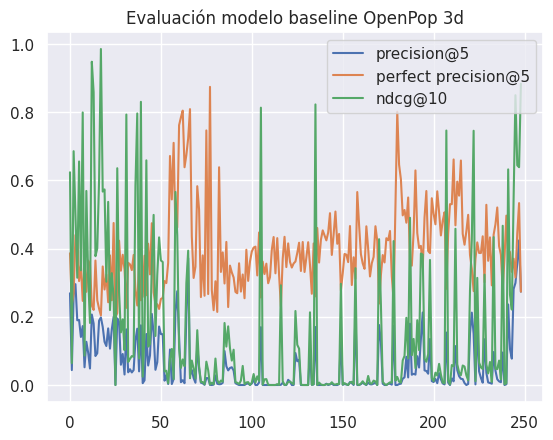

In [28]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = perfectmetrics['precision@5']
mdf['perfect precision@10'] = perfectmetrics['precision@10']
mdf['perfect map@10'] = perfectmetrics['map@10']
mdf[['precision@5', 'perfect precision@5', 'ndcg@10']].plot(title=f'Evaluación modelo baseline OpenPop {SPLITS_FREQ}')
mdf.describe()

In [29]:
mdf[-LAST_SPLITS:].describe()

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,perfect precision@5,perfect precision@10,perfect map@10
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.205477,0.429647,0.364597,0.549623,0.125778,0.469064,0.393785,0.651080,0.088641,0.477082,0.396575,0.676675,0.389292,0.213463,0.993517
std,0.149288,0.318356,0.306376,0.383190,0.088801,0.324137,0.308081,0.417107,0.056545,0.317622,0.305763,0.399028,0.080783,0.055816,0.009694
min,0.000000,0.000000,0.000000,0.000000,0.002564,0.002243,0.000427,0.004274,0.001709,0.002243,0.000427,0.004274,0.273684,0.136842,0.978174
25%,0.084205,0.193247,0.121459,0.240225,0.063125,0.232035,0.149219,0.378354,0.059645,0.273043,0.160484,0.516787,0.339620,0.175989,0.985663
50%,0.254909,0.500832,0.360076,0.694861,0.129345,0.591072,0.442207,0.838326,0.090614,0.592433,0.442207,0.842109,0.372365,0.207105,1.000000
75%,0.294735,0.610692,0.559249,0.823471,0.183957,0.642654,0.578823,1.000000,0.122638,0.642654,0.579721,1.000000,0.430833,0.243056,1.000000
max,0.424242,0.883452,0.842105,1.000000,0.266667,0.883452,0.842105,1.000000,0.177778,0.883452,0.842105,1.000000,0.533333,0.323596,1.000000


,t,model,variable,value
0,2021-06-30 23:48:50,openpop,precision@5,0.268966
1,2021-07-02 17:09:24,openpop,precision@5,0.043750
2,2021-07-06 23:57:13,openpop,precision@5,0.264516
3,2021-07-09 23:24:00,openpop,precision@5,0.295652
4,2021-07-12 23:50:23,openpop,precision@5,0.189655
...,...,...,...,...
991,2023-07-02 20:52:40,perfect,recall@5,0.987654
992,2023-07-05 23:57:06,perfect,recall@5,0.999294
993,2023-07-08 23:37:10,perfect,recall@5,1.000000
994,2023-07-11 23:24:07,perfect,recall@5,1.000000


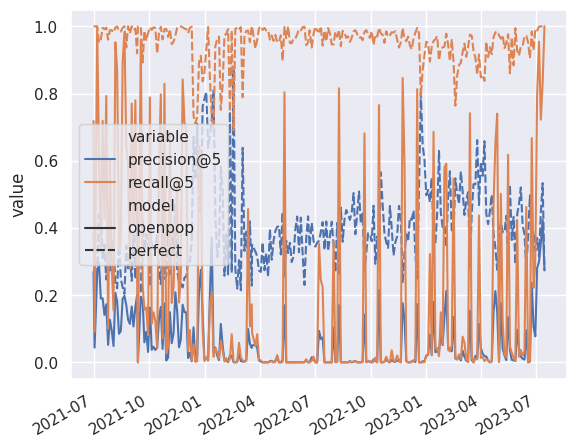

In [30]:
_METRICS = ['precision@5', 'recall@5']

_toplot = pd.concat([
    pd.DataFrame(metrics).assign(model='openpop'),
    pd.DataFrame(perfectmetrics).assign(model='perfect')
])
_toplot = _toplot[['t', 'model'] + _METRICS].melt(id_vars=['t', 'model'])
display(_toplot)

sns.lineplot(_toplot, x='t', y='value', hue='variable', style='model')
plt.xlabel("")
plt.xticks(rotation=30, ha='right');

In [31]:
def _plot_metric(metric):
    _toplot = pd.concat([
        pd.DataFrame(metrics).assign(model='openpop'),
        pd.DataFrame(perfectmetrics).assign(model='perfect')
    ])

    display(_toplot)
    ax = sns.lineplot(_toplot, x='t', y=metric, style='model')
    plt.xlabel("")
    plt.xticks(rotation=30, ha='right');
    return ax

nbutils.download_matplotlib(ax.figure, f'10_all_precision@5_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

Cannot show ipywidgets in text

,t,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15,model
0,2021-06-30 23:48:50,0.268966,0.623668,0.533525,0.718391,0.134483,0.623668,0.533525,0.718391,0.089655,0.623668,0.533525,0.718391,openpop
1,2021-07-02 17:09:24,0.043750,0.064025,0.042969,0.091146,0.021875,0.064025,0.042969,0.091146,0.014583,0.064025,0.042969,0.091146,openpop
2,2021-07-06 23:57:13,0.264516,0.685493,0.574014,0.997849,0.132258,0.685493,0.574014,0.997849,0.088172,0.685493,0.574014,0.997849,openpop
3,2021-07-09 23:24:00,0.295652,0.405641,0.254208,0.615497,0.239130,0.498665,0.353214,0.879502,0.176812,0.536593,0.375040,1.000000,openpop
4,2021-07-12 23:50:23,0.189655,0.253771,0.151734,0.330306,0.151724,0.314478,0.196433,0.504167,0.137931,0.364735,0.229773,0.654044,openpop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-07-02 20:52:40,0.370370,1.000000,0.987654,0.987654,0.192593,1.000000,1.000000,1.000000,0.128395,1.000000,1.000000,1.000000,perfect
245,2023-07-05 23:57:06,0.315254,1.000000,0.999294,0.999294,0.158051,1.000000,1.000000,1.000000,0.105367,1.000000,1.000000,1.000000,perfect
246,2023-07-08 23:37:10,0.444444,1.000000,1.000000,1.000000,0.222222,1.000000,1.000000,1.000000,0.148148,1.000000,1.000000,1.000000,perfect
247,2023-07-11 23:24:07,0.533333,1.000000,1.000000,1.000000,0.266667,1.000000,1.000000,1.000000,0.177778,1.000000,1.000000,1.000000,perfect


Cannot show ipywidgets in text

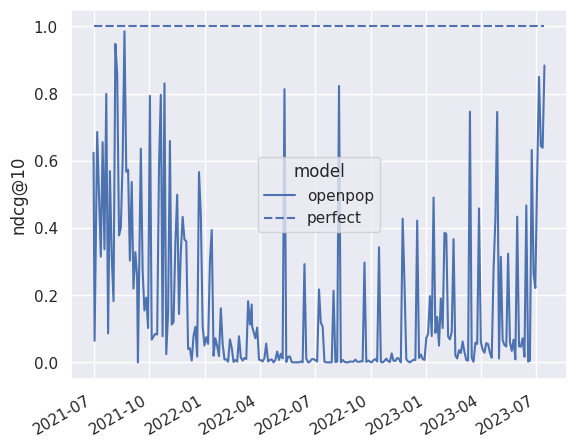

In [32]:
ax = _plot_metric('ndcg@10')
nbutils.download_matplotlib(ax.figure, f'10_all_ndcg@10_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

In [33]:
pmdf

,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
0,0.335570,1.0,0.967762,0.967762,0.193960,1.0,0.994916,0.994916,0.131991,1.0,0.996644,0.996644
1,0.386161,1.0,0.983731,0.983731,0.205357,1.0,0.996162,0.996162,0.139286,1.0,0.998110,0.998110
2,0.367647,1.0,0.927349,0.927349,0.234559,1.0,0.961039,0.961039,0.179657,1.0,0.977726,0.977726
3,0.340385,1.0,0.972941,0.972941,0.188942,1.0,0.985813,0.985813,0.134615,1.0,0.991940,0.991940
4,0.390533,1.0,0.971036,0.971036,0.215089,1.0,0.985348,0.985348,0.150099,1.0,0.988569,0.988569
5,0.439640,1.0,0.956153,0.956153,0.253453,1.0,0.987464,0.987464,0.178579,1.0,0.996354,0.996354
6,0.392440,1.0,0.955843,0.955843,0.230241,1.0,0.987711,0.987711,0.163345,1.0,0.997240,0.997240
7,0.518415,1.0,0.917098,0.917098,0.324709,1.0,0.977858,0.977858,0.231391,1.0,0.991084,0.991084
8,0.407018,1.0,0.934966,0.934966,0.250000,1.0,0.972619,0.972619,0.184503,1.0,0.986135,0.986135
9,0.376613,1.0,0.955346,0.955346,0.221371,1.0,0.986105,0.986105,0.157527,1.0,0.994928,0.994928


,precision@5,ndcg@5,map@5,recall@5,precision@10,ndcg@10,map@10,recall@10,precision@15,ndcg@15,map@15,recall@15
count,249.000000,249.0,249.000000,249.000000,249.000000,249.0,249.000000,249.000000,249.000000,249.0,249.000000,249.000000
mean,0.396961,1.0,0.952252,0.952252,0.235144,1.0,0.986779,0.986779,0.165499,1.0,0.993810,0.993810
std,0.124767,0.0,0.059109,0.059109,0.103590,0.0,0.023399,0.023399,0.076755,0.0,0.013898,0.013898
min,0.200000,1.0,0.690070,0.690070,0.100000,1.0,0.792551,0.792551,0.066667,1.0,0.873783,0.873783
25%,0.316239,1.0,0.941120,0.941120,0.171053,1.0,0.983910,0.983910,0.116119,1.0,0.993471,0.993471
50%,0.380000,1.0,0.970653,0.970653,0.213793,1.0,0.995042,0.995042,0.148718,1.0,0.998882,0.998882
75%,0.447887,1.0,0.988749,0.988749,0.264151,1.0,1.000000,1.000000,0.189583,1.0,1.000000,1.000000
max,0.874120,1.0,1.000000,1.000000,0.687785,1.0,1.000000,1.000000,0.458523,1.0,1.000000,1.000000


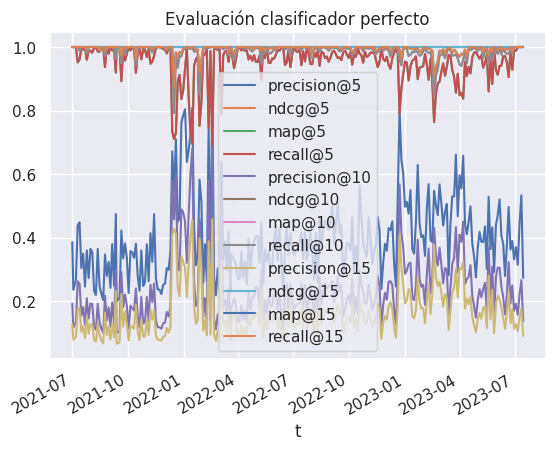

In [34]:
from src.baseline import write_metrics_perfect

pmdf = pd.DataFrame(perfectmetrics).set_index('t')

# pmdf.to_csv(paths.perfect_mp_freq(ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE))
write_metrics_perfect(pmdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
pmdf.plot(title='Evaluación clasificador perfecto')
pmdf.describe()

## Exploring the folds

In [35]:
print(f"There are {len(folds)} folds")
print(f"From {df['timestamp'].min()} to {df['timestamp'].max()}")

full_len = len(df)
fold_len = []
for tr, ts, t, open_proposals in timeFreqSplitCurrent(df, SPLITS_FREQ, dfp, return_open=True, normalize=SPLITS_NORMALIZE):
    fold_len.append({
        't': t,
        'train': len(tr),
        'test': len(ts),
        'open': len(open_proposals),
        'test users': ts['userID'].nunique(),
        'test vpv': ts['userID'].nunique() / len(ts) if len(ts) else np.NaN,
        'test vpp': ts['userID'].nunique() / ts['itemID'].nunique() if len(ts) else np.NaN,
        # 't_train_min': tr['timestamp'].min(),
        # 't_train_max': tr['timestamp'].max(),
        't_test_min': ts['timestamp'].min(),
        't_test_max': ts['timestamp'].max(),
    })

fold_len = pd.DataFrame(fold_len)
fold_len.describe()

There are 249 folds
From 2021-06-28 12:14:46 to 2023-07-20 03:54:45


,train,test,open,test users,test vpv,test vpp
count,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000
mean,284281.305221,872.795181,80.686747,389.485944,0.468723,9.042771
std,160012.654334,1272.656845,27.858627,751.636468,0.190256,17.603058
min,2771.000000,17.000000,2.000000,4.000000,0.093023,0.129032
25%,174580.000000,242.000000,68.000000,102.000000,0.330409,2.571429
50%,305895.000000,377.000000,85.000000,157.000000,0.443983,4.277778
75%,406220.000000,882.000000,96.000000,360.000000,0.582524,8.028986
max,532325.000000,10113.000000,161.000000,8586.000000,0.987154,206.090909


In [36]:
fold_len

,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max
0,2021-07-01,2771,675,6,554,0.820741,92.333333,2021-07-01 00:07:41,2021-07-02 16:09:30
1,2021-07-04,3487,107,4,96,0.897196,24.000000,2021-07-06 17:51:56,2021-07-06 23:57:13
2,2021-07-07,3594,273,5,218,0.798535,43.600000,2021-07-07 00:12:40,2021-07-09 17:48:45
3,2021-07-10,4476,185,13,75,0.405405,5.769231,2021-07-10 01:41:32,2021-07-12 22:52:02
4,2021-07-13,4870,275,17,112,0.407273,6.588235,2021-07-13 00:05:19,2021-07-15 22:47:40
...,...,...,...,...,...,...,...,...,...
244,2023-07-03,529754,83,7,39,0.469880,5.571429,2023-07-03 00:13:01,2023-07-05 21:41:49
245,2023-07-06,531109,491,9,302,0.615071,33.555556,2023-07-06 00:01:14,2023-07-08 23:37:10
246,2023-07-09,532202,28,6,13,0.464286,2.166667,2023-07-09 13:16:21,2023-07-11 23:24:07
247,2023-07-12,532230,95,6,40,0.421053,8.000000,2023-07-12 03:11:29,2023-07-14 23:03:25


In [37]:
# Get folds with more than 10 open proposals
MIN_OPEN = 10 # obviously, to test @10, we need 10 open proposals
MIN_USERS = 5
MIN_VPP = 1

MIN_FOLDS = 10 + 1

# fold_len['min_open'] = (fold_len['open'] >= MIN_OPEN) & (fold_len['test users'] >= MIN_USERS)
fold_len['min'] = (fold_len['open'] >= MIN_OPEN)
print("There are", fold_len['min'].sum(), "folds that could be used")
fold_len['min_window'] = fold_len.rolling(MIN_FOLDS)['min'].sum() >= MIN_FOLDS
fold_len[fold_len['min_window']].tail(20)

There are 241 folds that could be used


,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max,min,min_window
224,2023-05-04,504667,535,65,211,0.394393,5.275000,2023-05-04 00:11:16,2023-05-06 23:37:57,True,True
225,2023-05-07,506282,420,68,189,0.450000,4.395349,2023-05-07 00:10:36,2023-05-09 19:45:15,True,True
226,2023-05-10,507895,268,69,97,0.361940,2.771429,2023-05-10 01:15:48,2023-05-12 23:04:26,True,True
227,2023-05-13,509082,328,76,119,0.362805,2.586957,2023-05-13 00:52:30,2023-05-15 23:55:06,True,True
228,2023-05-16,510010,492,74,289,0.587398,6.282609,2023-05-16 00:02:09,2023-05-18 23:42:14,True,True
229,2023-05-19,511053,400,73,88,0.220000,1.600000,2023-05-19 00:24:15,2023-05-21 23:31:43,True,True
230,2023-05-22,512305,338,80,156,0.461538,3.627907,2023-05-22 00:59:00,2023-05-24 23:23:46,True,True
231,2023-05-25,512761,323,88,89,0.275542,2.405405,2023-05-25 01:20:43,2023-05-27 18:30:43,True,True
232,2023-05-28,514675,293,95,189,0.645051,7.875000,2023-05-28 00:16:51,2023-05-30 21:24:44,True,True
233,2023-05-31,516030,962,68,342,0.355509,7.125000,2023-05-31 00:06:32,2023-06-02 22:07:50,True,True


In [38]:
fold_len['min2'] = fold_len['min'] & (fold_len['test vpp'] >= MIN_VPP)
print("There are", fold_len['min2'].sum(), "folds that could be used")
fold_len['min2_window'] = fold_len.rolling(MIN_FOLDS)['min2'].sum() >= MIN_FOLDS
fold_len[fold_len['min2_window']].tail(20)

There are 237 folds that could be used


,t,train,test,open,test users,test vpv,test vpp,t_test_min,t_test_max,min,min_window,min2,min2_window
224,2023-05-04,504667,535,65,211,0.394393,5.275000,2023-05-04 00:11:16,2023-05-06 23:37:57,True,True,True,True
225,2023-05-07,506282,420,68,189,0.450000,4.395349,2023-05-07 00:10:36,2023-05-09 19:45:15,True,True,True,True
226,2023-05-10,507895,268,69,97,0.361940,2.771429,2023-05-10 01:15:48,2023-05-12 23:04:26,True,True,True,True
227,2023-05-13,509082,328,76,119,0.362805,2.586957,2023-05-13 00:52:30,2023-05-15 23:55:06,True,True,True,True
228,2023-05-16,510010,492,74,289,0.587398,6.282609,2023-05-16 00:02:09,2023-05-18 23:42:14,True,True,True,True
229,2023-05-19,511053,400,73,88,0.220000,1.600000,2023-05-19 00:24:15,2023-05-21 23:31:43,True,True,True,True
230,2023-05-22,512305,338,80,156,0.461538,3.627907,2023-05-22 00:59:00,2023-05-24 23:23:46,True,True,True,True
231,2023-05-25,512761,323,88,89,0.275542,2.405405,2023-05-25 01:20:43,2023-05-27 18:30:43,True,True,True,True
232,2023-05-28,514675,293,95,189,0.645051,7.875000,2023-05-28 00:16:51,2023-05-30 21:24:44,True,True,True,True
233,2023-05-31,516030,962,68,342,0.355509,7.125000,2023-05-31 00:06:32,2023-06-02 22:07:50,True,True,True,True


            train  test  i
t                         
2021-07-01   2771   675  0
2021-07-04   3487   107  1
2021-07-07   3594   273  2
2021-07-10   4476   185  3
2021-07-13   4870   275  4
2021-07-16   6361   368  5
2021-07-19   7214   181  6
2021-07-22   8375   451  7
2021-07-25   9274   195  8
2021-07-28   9941   286  9


Cannot show ipywidgets in text

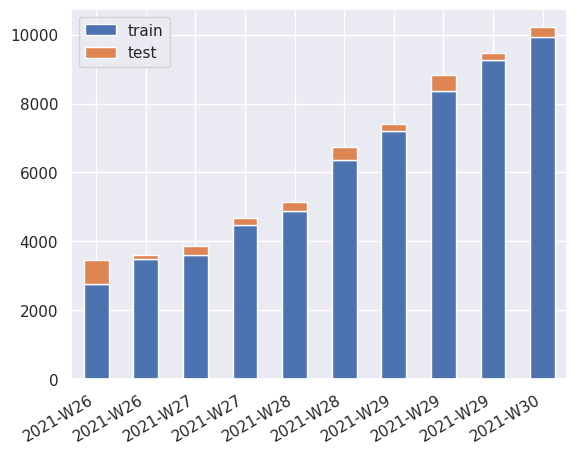

In [39]:
FIRST_FOLDS = 10
LAST_FOLDS = 0

# Bosquejo usando pandas.plot
_toplot = fold_len.set_index('t')[['train', 'test']]
_toplot['i'] = fold_len.index

_toplot = _toplot[ (_toplot['i'] < FIRST_FOLDS) | (_toplot['i'] > (len(_toplot) - LAST_FOLDS)) ]

print(_toplot)
ax = _toplot[['train', 'test']].plot.bar(stacked=True)
ax.set_xticks(np.arange(10), _toplot.index.strftime('%G-W%V'), rotation=30, ha='right')
ax.set_xlabel("")

nbutils.download_matplotlib(ax.figure, f'10_first_folds_{SPLITS_FREQ}_{SPLITS_NORMALIZE}_{ORG_NAME}.pdf')

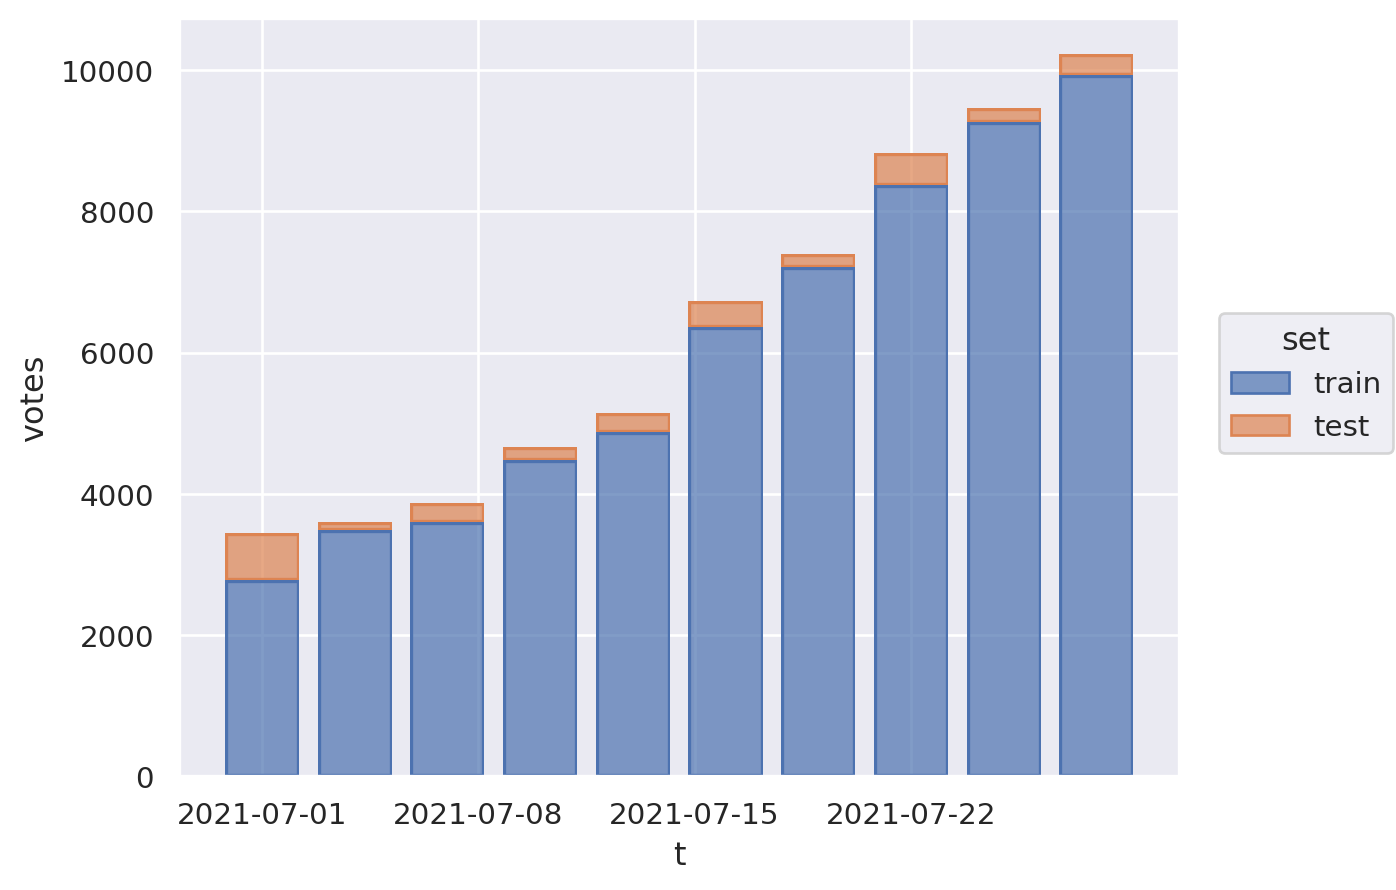

In [40]:
# Definitivo en seaborn
import seaborn.objects as so

_toplot = fold_len.assign(i=fold_len.index).melt(id_vars=['t', 'i'], value_vars=['train', 'test'], var_name='set', value_name='votes')
_toplot = _toplot[_toplot['i'] < FIRST_FOLDS]
so.Plot(_toplot, x='t', y='votes', color='set').add(so.Bar(), so.Stack())